In [56]:
%matplotlib notebook
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA 
from random import random
from statsmodels.tsa.stattools import adfuller
sns.set_style('whitegrid')

In [57]:
storage_delay = 30
pay_delay = 60
self_price = 1
sell_price = 2
discont_price = 1.5
min_pay = 10
storage_pay = 0.1

In [58]:
df = pd.read_csv('data.csv', sep=';')
df.drop(['День п/п', 'Unnamed: 7', 'Дней пр.'], axis=1, inplace = True)
df.set_index('Дата', inplace = True)
df.drop('Склад', inplace = True)
df.index = pd.to_datetime(df.index, format='%d.%m.%Y')
df.fillna(0, inplace = True)

<IPython.core.display.Javascript object>


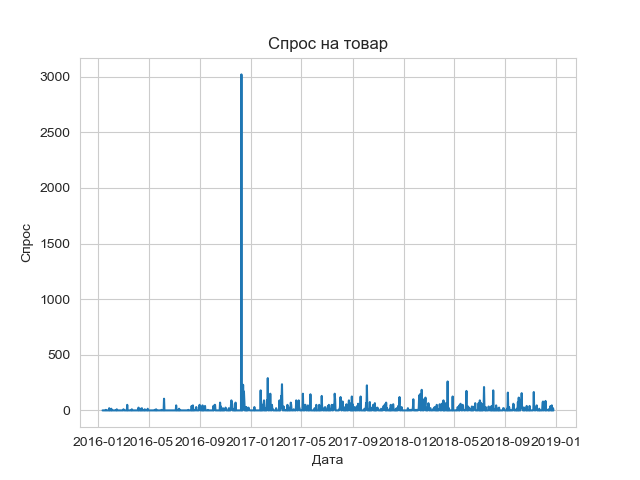

In [59]:
plt.figure()
plt.title('Спрос на товар')
plt.plot(df['Расход'])
plt.xlabel('Дата')
plt.ylabel('Спрос');

<IPython.core.display.Javascript object>


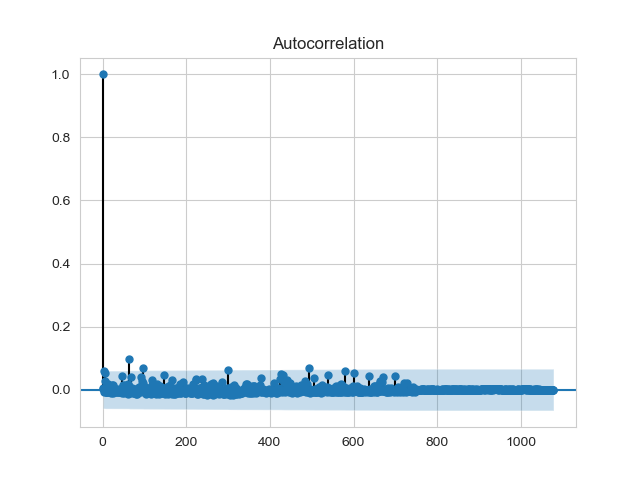

<IPython.core.display.Javascript object>


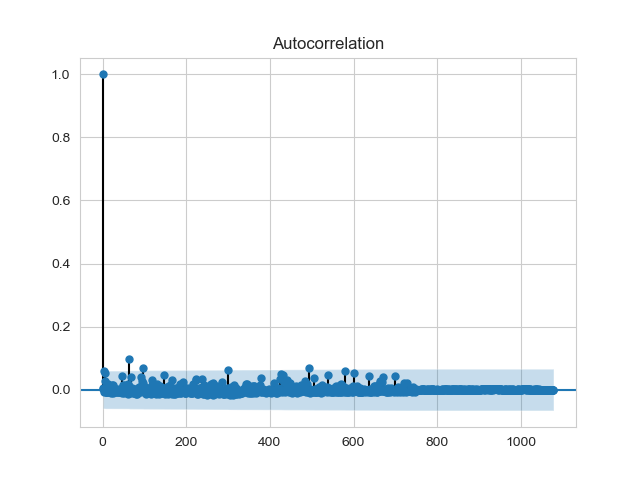

In [6]:
plot_acf(df['Расход'])

In [110]:
adfuller(df["Расход"])

(-32.67738393345393,
 0.0,
 0,
 1078,
 {'1%': -3.4364306491488814,
  '5%': -2.8642248442477976,
  '10%': -2.5681995044075987},
 12687.029472963042)

In [156]:
df['На складе AR'] = 0
df['Приход AR'] = 0
df['predict'] = 0
df.loc[df.index[0], 'На складе AR'] = df['На складе'][0]
last_order = 0
for i in tqdm(range(30, 1079)):
    p = df['Расход'].copy().values[:i]
    p[p>2000] = 0
    model = AR(p)
    model_fit = model.fit()
    predict_30 = model_fit.predict(i, i+30)
    predict_60 = model_fit.predict(i, i+60)
    df.loc[df.index[i], 'На складе AR'] = df.loc[df.index[i-1], 'На складе AR'] + df.loc[df.index[i], 'Приход AR'] - df.loc[df.index[i], 'Расход']
    predict_storage = df.loc[df.index[i], 'На складе AR'] - predict_30.sum() + df.loc[df.index[i:i+31], 'Приход AR'].sum()
    predict_ = df.loc[df.index[i], 'На складе AR'] - predict_60.sum() + df.loc[df.index[i:i+61], 'Приход AR'].sum()
    if predict_storage < 0 and i < 1050:
        df.loc[df.index[i+storage_delay], 'Приход AR']  = -predict_
        last_order = i

In [157]:
models = [('Используемая', 'Расход', 'Приход', 'На складе'),
          ('AR', 'Расход', 'Приход AR', 'На складе AR')]
for model in models:
    long_storage = 'long_storage ' + model[0]
    total_profit = 'total_profit ' + model[0]
    storage_cost = 'storage_cost ' + model[0]
    df[long_storage] = 0
    df[total_profit] = 0
    for i in tqdm(range(1079)):
        df.loc[df.index[i+storage_delay:], long_storage] += df.loc[df.index[i], model[2]]
        df.loc[df.index[i:], long_storage] -= df.loc[df.index[i], model[1]]
    df[long_storage] = np.maximum(df[long_storage], 0)
    df[storage_cost] = storage_pay * df[long_storage]
    df[storage_cost] += min_pay*(df[model[2]]>0) + df[model[2]]*self_price
    t = (sell_price * np.array(df[model[3]] > 0) 
     + discont_price*np.array(df[model[3]] < 0))
    df[total_profit] = np.cumsum(t*df[model[1]]) - np.cumsum(df[storage_cost])

In [158]:
df.head()

,д.н.,Приход,Расход,На складе,На складе AR,Приход AR,predict,long_storage Используемая,total_profit Используемая,storage_cost Используемая,long_storage AR,total_profit AR,storage_cost AR
Дата,,,,,,,,,,,,,
2016-01-12,3.0,0.0,0.0,52,52.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-13,4.0,0.0,0.0,52,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-14,5.0,0.0,0.0,52,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-15,6.0,0.0,0.0,52,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-16,7.0,0.0,0.0,52,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>


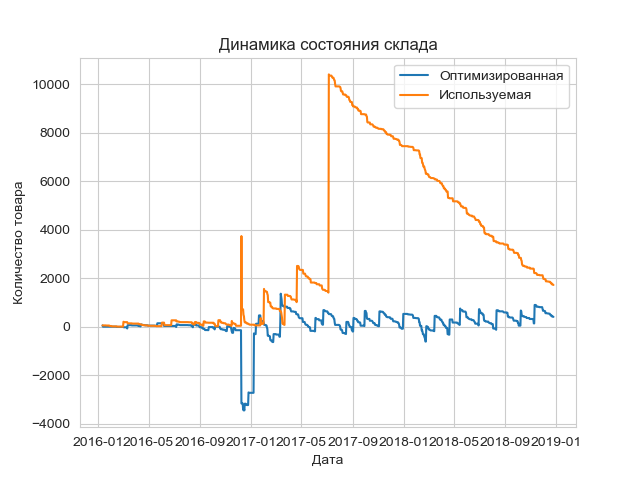

In [159]:
plt.figure()
plt.title('Динамика состояния склада')
plt.plot(df['На складе AR'])
plt.plot(df['На складе'])
plt.xlabel('Дата')
plt.ylabel('Количество товара')
plt.legend(['Оптимизированная', 'Используемая'])

<IPython.core.display.Javascript object>


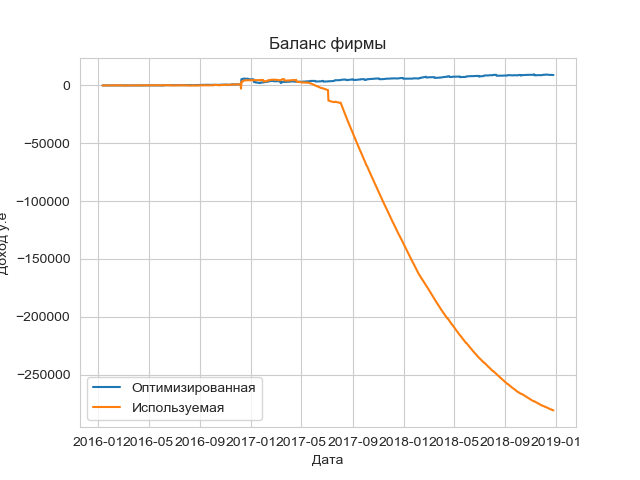

In [160]:
plt.figure()
plt.plot(df['total_profit AR'])
plt.plot(df['total_profit Используемая'])
plt.title('Баланс фирмы')
plt.xlabel('Дата')
plt.ylabel('Доход у.е')
plt.legend(['Оптимизированная', 'Используемая'])

<IPython.core.display.Javascript object>


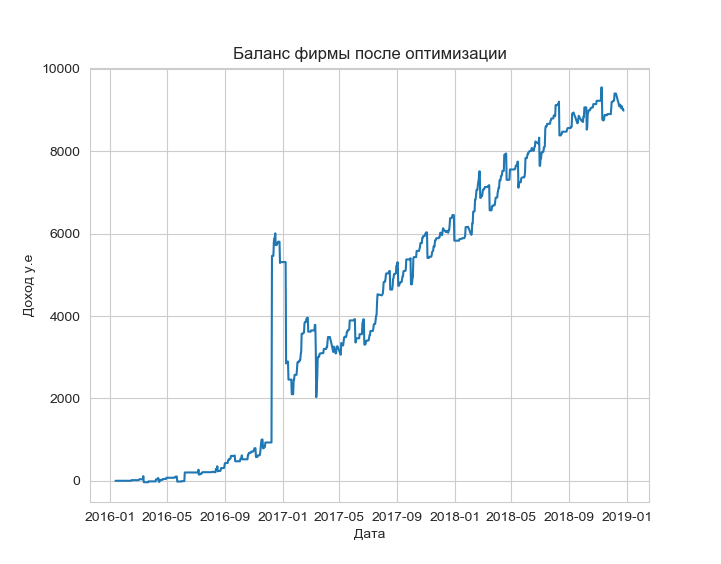

Text(0, 0.5, 'Доход у.е')

In [161]:
plt.figure()
plt.plot(df['total_profit AR'])
plt.title('Баланс фирмы после оптимизации')
plt.xlabel('Дата')
plt.ylabel('Доход у.е')

In [175]:
df = pd.read_csv('data.csv', sep=';')
df.drop(['День п/п', 'Unnamed: 7', 'Дней пр.'], axis=1, inplace = True)
df.set_index('Дата', inplace = True)
df.drop('Склад', inplace = True)
df.index = pd.to_datetime(df.index, format='%d.%m.%Y')
df.fillna(0, inplace = True)
df = df['Расход']

In [176]:
df1 = pd.read_csv('data_2.csv', sep =';')
df1 = df1[df1['ING'] == 4001]
df1 = df1[['Дата продажи', 'Кол-во']]
df1 = df1.set_index('Дата продажи')
df1.index = pd.to_datetime(df1.index, format='%d.%m.%Y')
df1 = df1['Кол-во']

In [177]:
df.head()

Дата
2016-01-12    0.0
2016-01-13    0.0
2016-01-14    0.0
2016-01-15    0.0
2016-01-16    0.0
Name: Расход, dtype: float64

In [178]:
df1.head()

Дата продажи
2019-01-14    20
2019-01-15    10
2019-01-16    60
2019-01-17    15
2019-01-18    20
Name: Кол-во, dtype: int64

In [179]:
data = pd.concat([df, df1, pd.Series(len(pd.date_range(start='04/11/2019', end='05/20/2019')), pd.date_range(start='04/11/2019', end='05/20/2019'))])

<IPython.core.display.Javascript object>


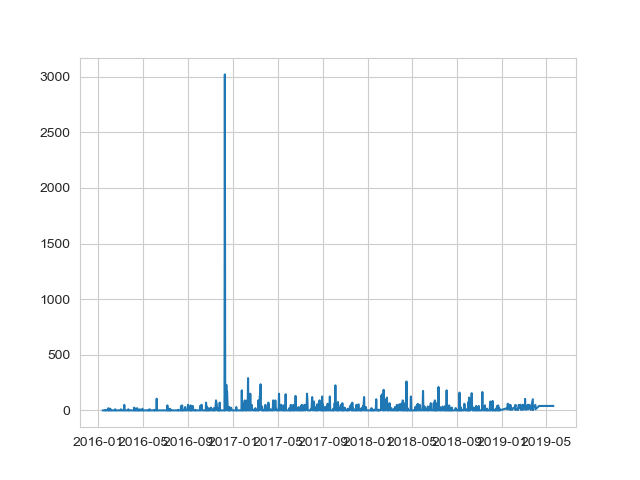

In [180]:
plt.figure()
plt.plot(data)

In [181]:
data = pd.DataFrame(data)
data = data.groupby(level=0).sum()

In [182]:
data.columns = ['Расход']

In [183]:
data.head()

,Расход
2016-01-12,0.0
2016-01-13,0.0
2016-01-14,0.0
2016-01-15,0.0
2016-01-16,0.0


In [184]:
data.shape

(1153, 1)

In [185]:
data['На складе AR'] = 0
data['Приход AR'] = 0
data.loc[data.index[0], 'На складе AR'] = 52
for i in tqdm(range(30, 1140)):
    p = data['Расход'].copy().values[:i]
    p[p>2000] = 0
    model = AR(p)
    model_fit = model.fit()
    predict_30 = model_fit.predict(i, i+30)
    predict_60 = model_fit.predict(i, i+80)
    data.loc[data.index[i], 'На складе AR'] = data.loc[data.index[i-1], 'На складе AR'] + data.loc[data.index[i], 'Приход AR'] - data.loc[data.index[i], 'Расход']
    predict_storage = data.loc[data.index[i], 'На складе AR'] - predict_30.sum() + data.loc[data.index[i:i+31], 'Приход AR'].sum()
    predict_ = data.loc[data.index[i], 'На складе AR'] - predict_60.sum() + data.loc[data.index[i:i+61], 'Приход AR'].sum()
    if predict_storage < 0:
        try:
            data.loc[data.index[i+storage_delay], 'Приход AR']  = -predict_
        except:
            pass

<IPython.core.display.Javascript object>


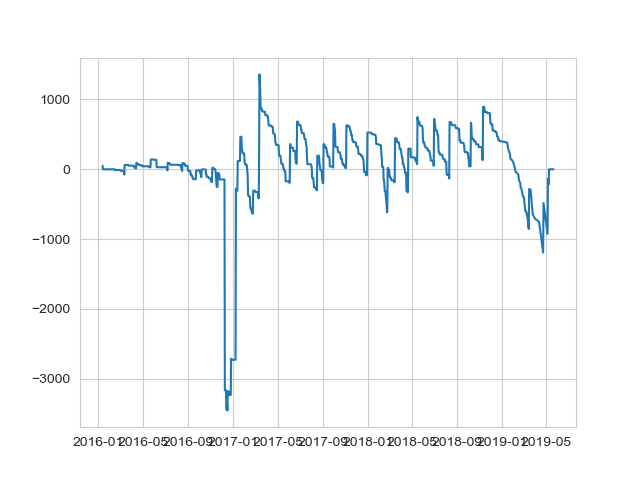

In [186]:
plt.figure()
plt.plot(data['На складе AR'])

In [187]:
df = data
models = [('AR', 'Расход', 'Приход AR', 'На складе AR')]
for model in models:
    long_storage = 'long_storage ' + model[0]
    total_profit = 'total_profit ' + model[0]
    storage_cost = 'storage_cost ' + model[0]
    df[long_storage] = 0
    df[total_profit] = 0
    for i in tqdm(range(1140)):
        df.loc[df.index[i+storage_delay:], long_storage] += df.loc[df.index[i], model[2]]
        df.loc[df.index[i:], long_storage] -= df.loc[df.index[i], model[1]]
    df[long_storage] = np.maximum(df[long_storage], 0)
    df[storage_cost] = storage_pay * df[long_storage]
    df[storage_cost] += min_pay*(df[model[2]]>0) + df[model[2]]*self_price
    t = (sell_price * np.array(df[model[3]] > 0) 
     + discont_price*np.array(df[model[3]] < 0))
    df[total_profit] = np.cumsum(t*df[model[1]]) - np.cumsum(df[storage_cost])

<IPython.core.display.Javascript object>


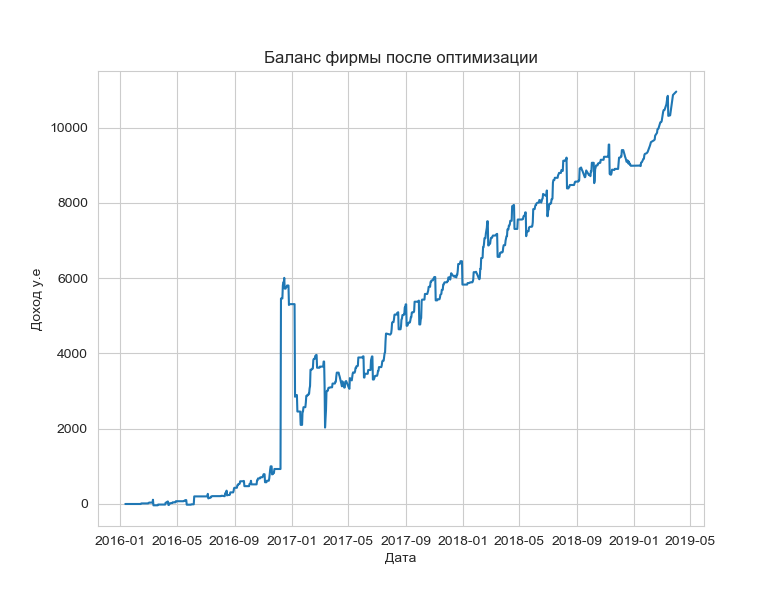

Text(0, 0.5, 'Доход у.е')

In [194]:
plt.figure()
plt.plot(df['total_profit AR'][:-40])
plt.title('Баланс фирмы после оптимизации')
plt.xlabel('Дата')
plt.ylabel('Доход у.е')